# Credit Scoring

In [1]:
from pandas import Series
import pandas as pd
import numpy as np
from datetime import datetime
import re


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV


from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

## DATA

In [2]:
DATA_DIR = '/kaggle/input/scoring-ring/'
df_train = pd.read_csv(DATA_DIR+'/train.csv')
df_test = pd.read_csv(DATA_DIR+'/test.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [4]:
df_train.default.value_counts()

0    64427
1     9372
Name: default, dtype: int64

In [5]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

In [6]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24354 entries, 0 to 24353
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   client_id  24354 non-null  int64  
 1   default    24354 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 380.7 KB


In [7]:
# дря корректной обработки признаков объединяем трейн и тест в один датасет

df_train['sample'] = 1 # помечаем трейн
df_test['sample'] = 0 # помечаем тест
df_test['default'] = 0 # в тесте нет значения default, его нужно предсказать, по этому пока заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем тест и трейн

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

## Cleaning and Prepping Data

Среди признаков те, что уже рассматривались в предыдущих заданиях:
* client_id - идентификатор клиента
* education - уровень образования
* sex - пол заёмщика
* age - возраст заёмщика
* car - флаг наличия автомобиля
* car_type - флаг автомобиля-иномарки
* decline_app_cnt - количество отказанных прошлых заявок
* good_work - флаг наличия «хорошей» работы
* bki_request_cnt - количество запросов в БКИ
* home_address - категоризатор домашнего адреса
* work_address - категоризатор рабочего адреса
* income - доход заёмщика
* foreign_passport - наличие загранпаспорта
* default - наличие дефолта

А также присутствуют новые признаки:
* app_date - дата подачи заявки
* score_bki - скоринговый балл по данным из БКИ
* region_rating - рейтинг региона 
* sna - связь заемщика с клиентами банка  
* first_time - давность наличия информации о заемщике


## education

Среди всех признаков только education имеет пропуски (478): 

In [9]:
data['education'].isna().sum()

478

In [10]:
data['education'].value_counts()

SCH    57998
GRD    34768
UGR    14748
PGR     1865
ACD      291
Name: education, dtype: int64

<AxesSubplot:>

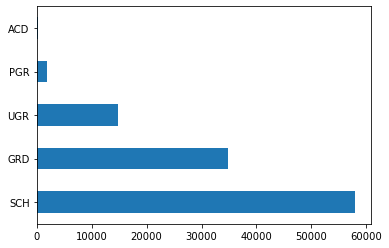

In [11]:
data['education'].value_counts().plot.barh()

Наличие пропусков в этом признаке может свидетельствовать о том, что во время заполнения анкеты это поле является необязательным и может быть пропущено. 
Пропуски заменим на новое значение 'N/A'. Также этот признак можно отнести к категориальным и применить к нему get_dummies.

In [12]:
data['education'] = data['education'].apply(lambda x: 'N/A' if pd.isna(x) else x)

In [13]:
data[data['sample']==1].pivot_table(index=['education'], values='default', aggfunc='mean', fill_value=0).sort_values(['default']) #Чем больше mean, тем больше дефолтов

,default
education,
ACD,0.041237
PGR,0.064439
GRD,0.090092
N/A,0.114007
UGR,0.131520
SCH,0.150592


Ализировав полученной таблицы: значение mean для признака N/A находится между значениями mean для GRD и UGR, и значительно отличается от значения mean для наиболее часто втречающегося признака SCH. Таким образом заполнение пропусков новым значением N/A более корректное, чем заполнение значением SCH



## app_date

In [14]:
data['app_date']

0         22MAR2014
1         24JAN2014
2         23MAR2014
3         03FEB2014
4         04FEB2014
            ...    
110143    04MAR2014
110144    24MAR2014
110145    22APR2014
110146    04JAN2014
110147    23JAN2014
Name: app_date, Length: 110148, dtype: object

In [15]:
data['app_date'].value_counts()

18MAR2014    1491
19MAR2014    1363
17MAR2014    1350
31MAR2014    1317
07APR2014    1296
             ... 
20APR2014     359
07JAN2014     349
03JAN2014     313
02JAN2014     204
01JAN2014      56
Name: app_date, Length: 120, dtype: int64

In [16]:
# Переведем значения данного признака во временной формат
data['app_date'] = data['app_date'].apply(lambda x: datetime.strptime(x, '%d%b%Y'))

In [17]:
data['app_date'].value_counts()

2014-03-18    1491
2014-03-19    1363
2014-03-17    1350
2014-03-31    1317
2014-04-07    1296
              ... 
2014-04-20     359
2014-01-07     349
2014-01-03     313
2014-01-02     204
2014-01-01      56
Name: app_date, Length: 120, dtype: int64

Все наблюдения датированы в промежутке c январь по апрель 2014 года

In [18]:
year = data['app_date'].apply(lambda x: x.year)
year.value_counts()

2014    110148
Name: app_date, dtype: int64

In [19]:
month = data['app_date'].apply(lambda x: x.month).rename('month', inplace=True)

month.value_counts()

3    31597
2    27097
4    26266
1    25188
Name: month, dtype: int64

In [20]:
weekday = data['app_date'].apply(lambda x: x.weekday()).rename('weekday', inplace=True)

weekday.value_counts()

1    18180
0    17858
2    17581
3    17421
4    16749
5    12202
6    10157
Name: weekday, dtype: int64

In [21]:
day = data['app_date'].apply(lambda x: x.day).rename('day', inplace=True)

day.value_counts()

17    4454
28    4338
18    4321
21    4230
11    4037
24    4035
14    3985
27    3924
15    3916
10    3836
4     3830
3     3818
20    3807
19    3737
22    3704
7     3642
5     3587
12    3559
25    3533
13    3471
16    3444
6     3412
9     3214
26    3141
1     2937
23    2899
30    2774
8     2747
2     2730
29    2553
31    2533
Name: day, dtype: int64

In [22]:
# Добавим дополнительные признаки месяц и день недели подачи заявки и :
data_proc = pd.concat([data, month, weekday, day], axis=1)




In [23]:
data_proc[data_proc['sample']==1]['month']

36349     2
36350     3
36351     2
36352     1
36353     4
         ..
110143    3
110144    3
110145    4
110146    1
110147    1
Name: month, Length: 73799, dtype: int64

In [24]:
data_proc[data_proc['sample']==1].pivot_table(index=['month'], values='default', aggfunc='mean', fill_value=0).sort_values(['default']) #Чем больше mean, тем больше дефолтов

,default
month,
4,0.105921
3,0.127538
2,0.132627
1,0.142342


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


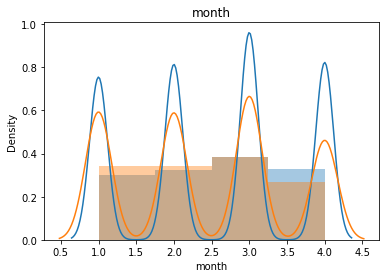

In [25]:
plt.figure()
sns.distplot(data_proc['month'][(data_proc['default'] == 0) & (data_proc['sample'] == 1)], hist=True, kde = True, rug=False, bins=4)
sns.distplot(data_proc['month'][data_proc['default'] == 1], hist=True, kde = True, rug=False, bins=4)
plt.title('month')
#plt.xlim(0,100000)
plt.show()

<AxesSubplot:xlabel='default', ylabel='month'>

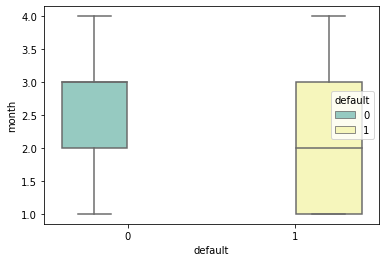

In [26]:
sns.boxplot(y='month', x='default', hue='default', data=data_proc[data_proc['sample']==1], palette="Set3")

In [27]:
data_proc[data_proc['sample']==1].pivot_table(index=['weekday'], values='default', aggfunc='mean', fill_value=0).sort_values(['default']) #Чем больше mean, тем больше дефолтов

,default
weekday,
4,0.119950
2,0.124276
0,0.127079
1,0.127382
6,0.129185
5,0.130968
3,0.131985


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


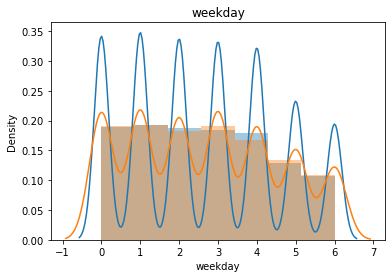

In [28]:
plt.figure()
sns.distplot(data_proc['weekday'][data['default'] == 0], hist=True, kde = True, rug=False, bins=7)
sns.distplot(data_proc['weekday'][data['default'] == 1], hist=True, kde = True, rug=False, bins=7)
plt.title('weekday')
#plt.xlim(0,100000)
plt.show()

<AxesSubplot:xlabel='default', ylabel='weekday'>

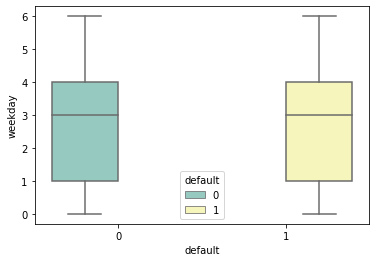

In [29]:
sns.boxplot(y='weekday', x='default', hue='default', data=data_proc[data_proc['sample']==1], palette="Set3")

In [30]:
data_proc[data_proc['sample']==1].pivot_table(index=['day'], values='default', aggfunc='mean', fill_value=0).sort_values(['default']) #Чем больше mean, тем больше дефолтов

,default
day,
21,0.111576
16,0.113456
24,0.113678
5,0.113814
10,0.114551
18,0.115811
11,0.116727
15,0.119970
19,0.122499


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


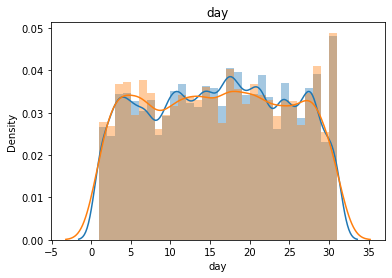

In [31]:
plt.figure()
sns.distplot(data_proc['day'][data['default'] == 0], hist=True, kde = True, rug=False, bins=30)
sns.distplot(data_proc['day'][data['default'] == 1], hist=True, kde = True, rug=False, bins=30)
plt.title('day')
#plt.xlim(0,100000)
plt.show()

<AxesSubplot:xlabel='default', ylabel='day'>

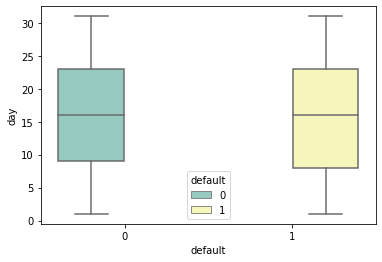

In [32]:
sns.boxplot(y='day', x='default', hue='default', data=data_proc[data_proc['sample']==1], palette="Set3")

Вывод: количество дефолтов скорее не зависит или слабо зависит от дня месяца или недели. При рассмотрении по месяцам, кажется, что в первый месяц дефолтов было больше, потом их количество снижалось. Этот признак можно будет использовать для построения модели.

## sex

In [33]:
data['sex'].value_counts()

F    61836
M    48312
Name: sex, dtype: int64

In [34]:
# Преобразуем значения в числа с помощью LabelEncoder
label_encoder = LabelEncoder()
data_proc['sex'] = label_encoder.fit_transform(data['sex'])
print('sex', dict(enumerate(label_encoder.classes_)))

sex {0: 'F', 1: 'M'}


In [35]:
data_proc[data_proc['sample']==1].pivot_table(index=['sex'], values='default', aggfunc='mean', fill_value=0).sort_values(['default']) #Чем больше mean, тем больше дефолтов

,default
sex,
0,0.121241
1,0.134411


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


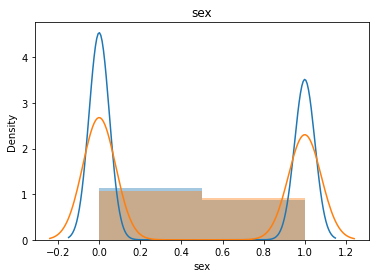

In [36]:
plt.figure()
sns.distplot(data_proc['sex'][data['default'] == 0], hist=True, kde = True, rug=False, bins=2)
sns.distplot(data_proc['sex'][data['default'] == 1], hist=True, kde = True, rug=False, bins=2)
plt.title('sex')
#plt.xlim(0,100000)
plt.show()

## age

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


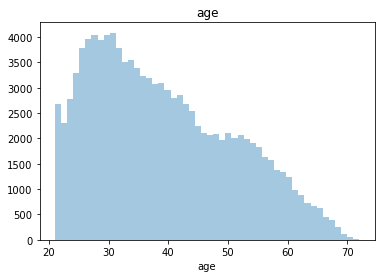

In [37]:
plt.figure()
sns.distplot(data_proc['age'], hist=True, kde = False, rug=False)
plt.title('age')
plt.show()

<AxesSubplot:xlabel='default', ylabel='age'>

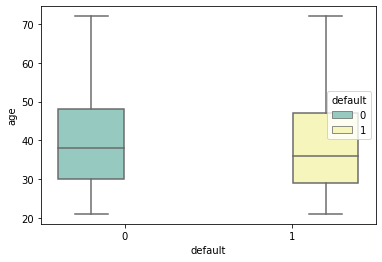

In [38]:
sns.boxplot(y='age', x='default', hue='default', data=data_proc[data_proc['sample']==1], palette="Set3")

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


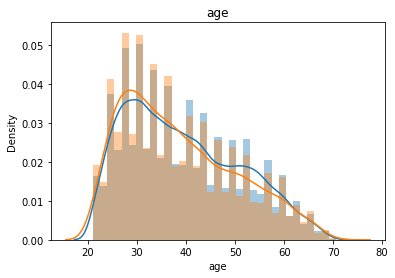

In [39]:
plt.figure()
sns.distplot(data_proc['age'][(data_proc['default'] == 0)  & (data_proc['sample']==1)], hist=True, kde = True, rug=False, bins=35)
sns.distplot(data_proc['age'][data_proc['default'] == 1], hist=True, kde = True, rug=False, bins=35)
plt.title('age')
#plt.xlim(0,100000)
plt.show()

Видно, что дефолты происходят немного чаще у людей более молодого возраста. Добавим новый призна 'age_40', который равен 1, если возраст > 40, и 0, если возраст < 40.

In [40]:
data_proc['age']

0         29
1         39
2         50
3         56
4         38
          ..
110143    45
110144    41
110145    31
110146    29
110147    34
Name: age, Length: 110148, dtype: int64

In [41]:
data_proc['age_40'] = data_proc['age'].apply(lambda x: 1 if 40<=x else 0)

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


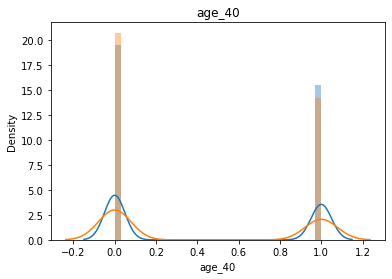

In [42]:
plt.figure()
sns.distplot(data_proc['age_40'][data['default'] == 0  & (data_proc['sample']==1)], hist=True, kde = True, rug=False, bins=35)
sns.distplot(data_proc['age_40'][data['default'] == 1], hist=True, kde = True, rug=False, bins=35)
plt.title('age_40')
#plt.xlim(0,100000)
plt.show()

In [43]:
data_proc[data_proc['sample']==1].pivot_table(index=['age_40'], values='default', aggfunc='mean', fill_value=0).sort_values(['default']) #Чем больше mean, тем больше дефолтов

,default
age_40,
1,0.117183
0,0.134738


## car

In [44]:
data['car'].value_counts()

N    74290
Y    35858
Name: car, dtype: int64

In [45]:
# Чтобы выразить значения бинарного признака в форме чисел, используем LabelEncoder
label_encoder = LabelEncoder()
data_proc['car'] = label_encoder.fit_transform(data_proc['car'])
print('car', dict(enumerate(label_encoder.classes_)))

car {0: 'N', 1: 'Y'}


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


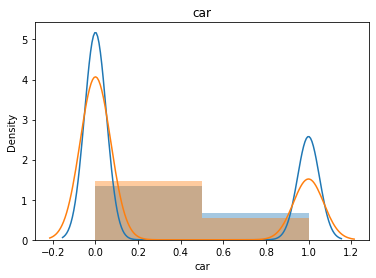

In [46]:
plt.figure()
sns.distplot(data_proc['car'][(data_proc['default'] == 0) & (data_proc['sample']==1)], hist=True, kde = True, rug=False, bins=2)
sns.distplot(data_proc['car'][data_proc['default'] == 1], hist=True, kde = True, rug=False, bins=2)
plt.title('car')
#plt.xlim(0,100000)
plt.show()

In [47]:
data_proc[data_proc['sample']==1].pivot_table(index=['car'], values='default', aggfunc='mean', fill_value=0).sort_values(['default']) #Чем больше mean, тем больше дефолтов

,default
car,
1,0.106271
0,0.136960


Случаев дефолтов меньше у людей с машиной

## car_type

In [48]:
data['car_type'].value_counts()

N    89140
Y    21008
Name: car_type, dtype: int64

In [49]:
data_proc['car_type'] = label_encoder.fit_transform(data_proc['car_type'])
print('car_type', dict(enumerate(label_encoder.classes_)))

car_type {0: 'N', 1: 'Y'}


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


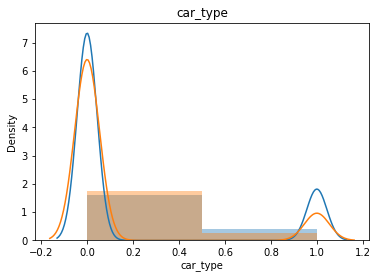

In [50]:
plt.figure()
sns.distplot(data_proc['car_type'][(data_proc['default'] == 0)  & (data_proc['sample']==1)], hist=True, kde = True, rug=False, bins=2)
sns.distplot(data_proc['car_type'][data_proc['default'] == 1], hist=True, kde = True, rug=False, bins=2)
plt.title('car_type')
#plt.xlim(0,100000)
plt.show()

In [51]:
data_proc[data_proc['sample']==1].pivot_table(index=['car_type'], values='default', aggfunc='mean', fill_value=0).sort_values(['default']) #Чем больше mean, тем больше дефолтов

,default
car_type,
1,0.087450
0,0.136258


In [52]:
#Добавим признак 'car_type_all', который объединяет данные по машине: 0 - машины нет, 1 - машина не иномарка, 2 - машина - иномарка
data_proc['car_all'] = data_proc['car'] + data_proc['car_type']

In [53]:
data_proc[data_proc['sample']==1].pivot_table(index=['car_all'], values='default', aggfunc='mean', fill_value=0).sort_values(['default']) #Чем больше mean, тем больше дефолтов

,default
car_all,
2,0.087450
1,0.132744
0,0.136960


Видно, что количество дефолтов у клиентов без машины и с отечественным автомобилем очень близки.

## decline_app_cnt

In [54]:
data['decline_app_cnt'].value_counts()

0     91471
1     12500
2      3622
3      1365
4       606
5       255
6       156
7        58
8        37
9        29
10       16
11       10
12        5
13        4
14        3
16        3
15        1
19        1
20        1
21        1
22        1
24        1
30        1
33        1
Name: decline_app_cnt, dtype: int64

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


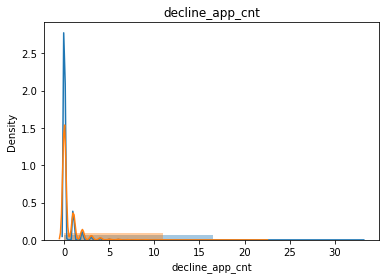

In [55]:
plt.figure()
sns.distplot(data_proc['decline_app_cnt'][(data_proc['default'] == 0)  & (data_proc['sample']==1)], hist=True, kde = True, rug=False, bins=2)
sns.distplot(data_proc['decline_app_cnt'][data_proc['default'] == 1], hist=True, kde = True, rug=False, bins=2)
plt.title('decline_app_cnt')
#plt.xlim(0,100000)
plt.show()

(0.0, 5.0)

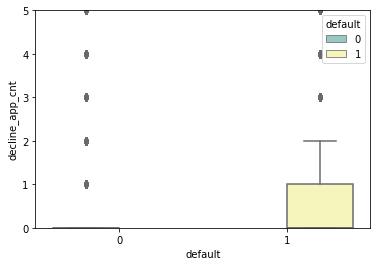

In [56]:
ax= sns.boxplot(y='decline_app_cnt', x='default', hue='default', data=data_proc[data_proc['sample']==1], palette="Set3")
ax.set_ylim(0,5)

In [57]:
data_proc[data_proc['sample']==1].pivot_table(index=['decline_app_cnt'], values='default', aggfunc='mean', fill_value=0).sort_values(['decline_app_cnt']).T #Чем больше mean, тем больше дефолтов

decline_app_cnt,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,19,22,24,33
default,0.109534,0.187805,0.243517,0.273533,0.289855,0.260606,0.300885,0.291667,0.526316,0.375,...,0.333333,0.0,0.0,0.5,1.0,0.0,1.0,1.0,0.0,0.0


В целом видна тенденция на увеличение количества дефолтов с увеличением числа отклонений, после 2 отклонений, значений слишком мало, чтобы оценить тенденцию, поэтому заменим все значения больше 2 на 2. что будет означать все случаи с числом отклонений более 2 раз. *Тестировались различные значения для замены, но в случае "2" количество выбросов было минимальным

In [58]:
data_proc['decline_app_cnt'] = data_proc['decline_app_cnt'].apply(lambda x: 2 if x>2 else x)

In [59]:
data_proc[data_proc['sample']==1].pivot_table(index=['decline_app_cnt'], values='default', aggfunc='mean', fill_value=0).sort_values(['decline_app_cnt']) #Чем больше mean, тем больше дефолтов

,default
decline_app_cnt,
0,0.109534
1,0.187805
2,0.260267


In [60]:
data_proc[data_proc['sample'] == 1]['decline_app_cnt'].value_counts()

0    61214
1     8397
2     4188
Name: decline_app_cnt, dtype: int64

<AxesSubplot:xlabel='default', ylabel='decline_app_cnt'>

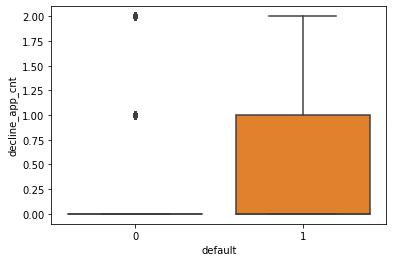

In [61]:
sns.boxplot(x='default', y= 'decline_app_cnt', data=data_proc[data_proc['sample'] == 1])

## good_work

In [62]:
data['good_work'].value_counts()

0    91917
1    18231
Name: good_work, dtype: int64

In [63]:
data_proc[data_proc['sample']==1].pivot_table(index=['good_work'], values='default', aggfunc='mean', fill_value=0).sort_values(['default']) #Чем больше mean, тем больше дефолтов

,default
good_work,
1,0.094502
0,0.133409


## score_bki

In [64]:
data['score_bki'].value_counts()

-1.775263    517
-2.104211    454
-2.225004    424
-2.169664    375
-2.024100    278
            ... 
-1.544707      1
-1.339377      1
-1.670881      1
-2.291558      1
-2.296371      1
Name: score_bki, Length: 102618, dtype: int64

<AxesSubplot:xlabel='default', ylabel='score_bki'>

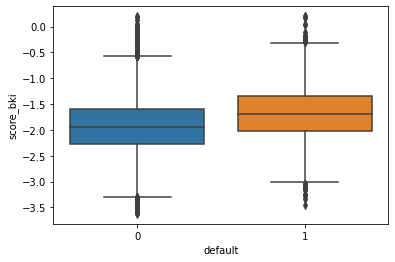

In [65]:
sns.boxplot(x='default', y= 'score_bki', data=data)
#ax.set(ylim=(0, 5))

In [66]:
data['score_bki'].max()

0.19977285

In [67]:
data['score_bki'].min()

-3.62458632

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


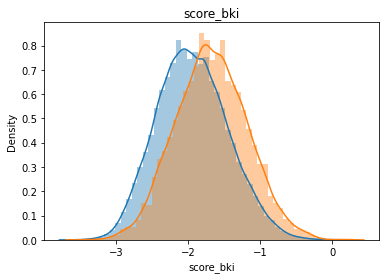

In [68]:
plt.figure()
sns.distplot(data['score_bki'][(data['default'] == 0) & (data['sample'] == 1)], hist=True, kde = True, rug=False)
sns.distplot(data['score_bki'][data['default'] == 1], hist=True, kde = True, rug=False)
plt.title('score_bki')
plt.show()

Значения признака лежат в промежутке от -3.7 до 0.2. Такие значения скорингового балла не соответствуют ни одной из скоринговых систем. В то же время признак распределен нормально, без явных выбросов. 

## bki_request_cnt

In [69]:
data['bki_request_cnt'].value_counts()

0     28908
1     27295
2     20481
3     13670
4      8406
5      4960
6      2500
7      1292
8       735
9       459
10      350
11      278
12      217
13      151
14      110
15       81
16       58
17       33
18       32
19       30
21       19
20       14
24       12
23       12
22        8
25        5
27        5
28        5
26        4
32        4
29        3
40        2
33        2
36        1
34        1
41        1
45        1
46        1
47        1
53        1
Name: bki_request_cnt, dtype: int64

In [70]:
data_proc[data_proc['sample']==1].pivot_table(index=['bki_request_cnt'], values='default', aggfunc='mean', fill_value=0).sort_values(['bki_request_cnt']) #Чем больше mean, тем больше дефолтовA

,default
bki_request_cnt,
0,0.094990
1,0.118790
2,0.132373
3,0.145641
4,0.151235
5,0.169523
6,0.163732
7,0.157277
8,0.192913


Здесь также можно выделить тенденцию на увеличение дефолтов с увеличением количества запросов. Чтобы выделить тенденцию в явном виде, произведем замену значений: 7 - если запросов от 7 до 9, и 8 - если запросов 10 и больше

In [71]:
data_proc['bki_request_cnt'] = data['bki_request_cnt'].apply(lambda x: 7 if x in [7, 8, 9] else x).apply(lambda x: 8 if x >= 10 else x)

In [72]:
data_proc[data_proc['sample']==1].pivot_table(index=['bki_request_cnt'], values='default', aggfunc='mean', fill_value=0).sort_values(['bki_request_cnt']) #Чем больше mean, тем больше дефолтов

,default
bki_request_cnt,
0,0.094990
1,0.118790
2,0.132373
3,0.145641
4,0.151235
5,0.169523
6,0.163732
7,0.174804
8,0.240506


In [73]:
data_proc['bki_request_cnt'].value_counts()

0    28908
1    27295
2    20481
3    13670
4     8406
5     4960
6     2500
7     2486
8     1442
Name: bki_request_cnt, dtype: int64

<AxesSubplot:xlabel='default', ylabel='bki_request_cnt'>

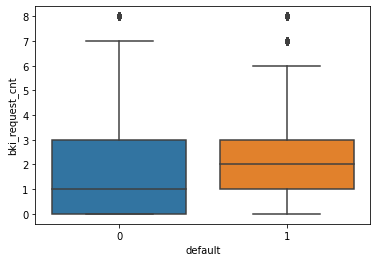

In [74]:
sns.boxplot(x='default', y= 'bki_request_cnt', data=data_proc[data_proc['sample']==1])

## region_rating

In [75]:
data['region_rating'].value_counts()

50    40981
60    23999
40    17947
80    17170
70     9304
30      434
20      313
Name: region_rating, dtype: int64

In [76]:
data_proc[data_proc['sample']==1].pivot_table(index=['region_rating'], values='default', aggfunc='mean', fill_value=0).sort_values(['region_rating']) #Чем больше mean, тем больше дефолтов

,default
region_rating,
20,0.213592
30,0.190000
40,0.169702
50,0.136141
60,0.128834
70,0.092434
80,0.073154


Здесь также видна тенденция на сокращение количества дефолтов с увеличением рейтинга региона

<AxesSubplot:xlabel='default', ylabel='region_rating'>

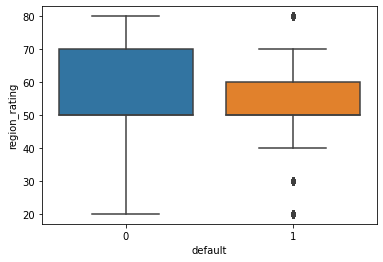

In [77]:
sns.boxplot(x='default', y= 'region_rating', data=data_proc[data_proc['sample']==1])

## home_address

In [78]:
data['home_address'].value_counts()

2    59591
1    48688
3     1869
Name: home_address, dtype: int64

In [79]:
data_proc[data_proc['sample']==1].pivot_table(index=['home_address'], values='default', aggfunc='mean', fill_value=0).sort_values(['home_address']) #Чем больше mean, тем больше дефолтов

,default
home_address,
1,0.092896
2,0.155146
3,0.116057


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


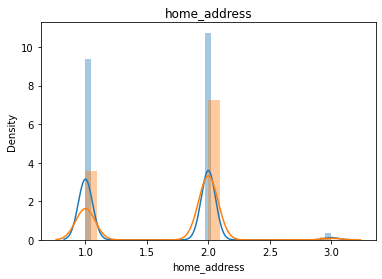

In [80]:
plt.figure()
sns.distplot(data['home_address'][(data['default'] == 0) & (data['sample'] == 1)], hist=True, kde = True, rug=False)
sns.distplot(data['home_address'][data['default'] == 1], hist=True, kde = True, rug=False)
plt.title('home_address')
plt.show()

## work_address

In [81]:
data['work_address'].value_counts()

3    67113
2    30761
1    12274
Name: work_address, dtype: int64

In [82]:
data[data['sample']==1].pivot_table(index=['work_address'], values='default', aggfunc='mean', fill_value=0).sort_values(['work_address']) #Чем больше mean, тем больше дефолтов

,default
work_address,
1,0.074154
2,0.102507
3,0.147957


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


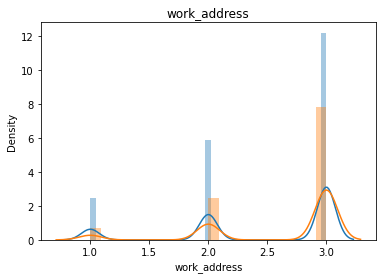

In [83]:
plt.figure()
sns.distplot(data['work_address'][(data['default'] == 0) & (data['sample'] == 1)], hist=True, kde = True, rug=False)
sns.distplot(data['work_address'][data['default'] == 1], hist=True, kde = True, rug=False)
plt.title('work_address')
plt.show()

## income

In [84]:
data['income'].value_counts()

30000     10437
25000      9090
20000      8174
40000      7383
50000      6742
          ...  
96500         1
14620         1
16723         1
154000        1
32400         1
Name: income, Length: 1207, dtype: int64

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


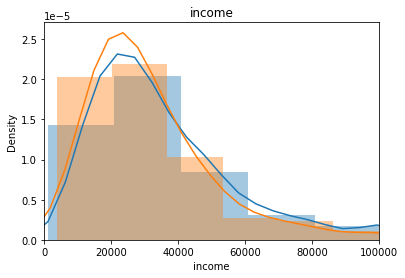

In [85]:
plt.figure()
sns.distplot(data['income'][(data['default'] == 0) & (data['sample'] == 1)], hist=True, kde = True, rug=False)
sns.distplot(data['income'][data['default'] == 1], hist=True, kde = True, rug=False)
plt.title('income')
plt.xlim(0,100000)
plt.show()

In [86]:
data['income'].min()

1000

In [87]:
data['income'].max()

1000000

<AxesSubplot:xlabel='default', ylabel='income'>

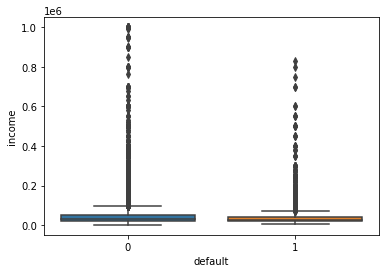

In [88]:
sns.boxplot(x='default', y= 'income', data=data[data['sample'] == 1])
#ax.set(ylim=(0, 5))

Здесь много выбросов. Тем не менее заметно, что чем больше зарплата, тем меньше дефотов. Создадим новый признак, который показывает порядок зарплаты:

In [89]:
data_proc['income_rank'] = data['income'].apply(lambda x: round(np.log10(x)))

In [90]:
data_proc['income_rank'].value_counts()

4    60123
5    49603
6      394
3       28
Name: income_rank, dtype: int64

In [91]:
data_proc[data['sample']==1].pivot_table(index=['income_rank'], values='default', aggfunc='mean', fill_value=0).sort_values(['income_rank']) #Чем больше mean, тем больше дефолтов

,default
income_rank,
3,0.000000
4,0.142499
5,0.108422
6,0.101124


Получилось, что при доходе уровня "3" - дефолтов не наблюдалось, но это может быть вызвано в том числе и из-за небольшого количества случаев. Объединим их с уровнем дохода "4". Для уровней дохода "5" и "6" разница маленькая, объединим и их тоже.

In [92]:
data_proc['income_rank'] = data['income'].apply(lambda x: 0 if round(np.log10(x))<=4 else 1)

In [93]:
data_proc[data['sample']==1].pivot_table(index=['income_rank'], values='default', aggfunc='mean', fill_value=0).sort_values(['income_rank']) #Чем больше mean, тем больше дефолтов

,default
income_rank,
0,0.142432
1,0.108363


## sna

In [94]:
data['sna'].value_counts()

1    70681
4    17481
2    15832
3     6154
Name: sna, dtype: int64

In [95]:
data_proc[data['sample']==1].pivot_table(index=['sna'], values='default', aggfunc='mean', fill_value=0).sort_values(['sna']) #Чем больше mean, тем больше дефолтов

,default
sna,
1,0.098201
2,0.149821
3,0.157652
4,0.211507


## first_time

In [96]:
data['first_time'].value_counts()

3    46588
4    28017
1    18296
2    17247
Name: first_time, dtype: int64

In [97]:
data_proc[data['sample']==1].pivot_table(index=['first_time'], values='default', aggfunc='mean', fill_value=0).sort_values(['first_time']) #Чем больше mean, тем больше дефолтов

,default
first_time,
1,0.186126
2,0.155429
3,0.120269
4,0.082030


## foreign_passport

In [98]:
data['foreign_passport'].value_counts()

N    93721
Y    16427
Name: foreign_passport, dtype: int64

In [99]:
data_proc['foreign_passport'] = label_encoder.fit_transform(data_proc['foreign_passport'])
print('foreign_passport', dict(enumerate(label_encoder.classes_)))

foreign_passport {0: 'N', 1: 'Y'}


In [100]:
data_proc[data['sample']==1].pivot_table(index=['foreign_passport'], values='default', aggfunc='mean', fill_value=0).sort_values(['foreign_passport']) #Чем больше mean, тем больше дефолтов

,default
foreign_passport,
0,0.136324
1,0.074101


## default 

Проверим, достаточно ли образцов с каждым значением default. В этом случае используем df_train, так как только в этой таблице есть оригинальные значения.

In [101]:
df_train['default'].value_counts()

0    64427
1     9372
Name: default, dtype: int64

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


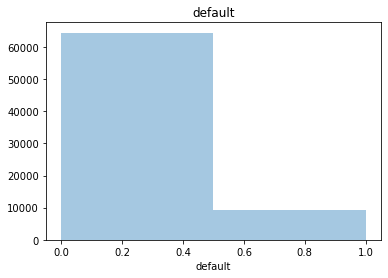

In [102]:
plt.figure()
sns.distplot(df_train['default'], hist=True, kde = False, rug=False, bins=2)
plt.title('default')
plt.show()

Количество случаев с положительным исходом составляет ~1/7 от всех случаев. Таким образом делаем вывод, что случаев обоих исходов достаточное количество.

In [103]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

# Data Preprocessing

In [104]:
DATA_DIR = '/kaggle/input/scoring-ring/'
df_train = pd.read_csv(DATA_DIR+'/train.csv')
df_test = pd.read_csv(DATA_DIR+'/test.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')
df_train['sample'] = 1 # помечаем трейн
df_test['sample'] = 0 # помечаем тест
df_test['default'] = 0 # в тесте нет значения default, его нужно предсказать, по этому пока заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем тест и трейн

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

In [105]:
del_col = ['app_date'] 

In [106]:
def preproc_data(df_input):
    
    df_output = df_input.copy()
    
    '''Заполнение пропусков в признаке education'''
    df_output['education'] = df_output['education'].apply(lambda x: 'N/A' if pd.isna(x) else x)
    
    '''Преобразование значений признака app_date во временной формат'''
    df_output['app_date'] = df_output['app_date'].apply(lambda x: datetime.strptime(x, '%d%b%Y'))
    
    '''Новый признак month - месяц подачи заявки'''
    df_output['month'] = df_output['app_date'].apply(lambda x: x.month).rename('month', inplace=True)
    
    '''Новый признак age_40 - бинарный признак'''
    df_output['age_40'] = df_output['age'].apply(lambda x: 1 if 40<=x else 0)
    
    '''Преобразоваие значений признака decline_app_cnt - категориальный признак'''
    df_output['decline_app_cnt'] = df_output['decline_app_cnt'].apply(lambda x: 2 if x>2 else x)
    
    '''Преобразоваие значений признака bki_request_cnt - категориальный признак'''
    df_output['bki_request_cnt'] = df_output['bki_request_cnt'].apply(lambda x: 7 if x in [7, 8, 9] else x).apply(lambda x: 8 if x >= 10 else x)
    
    '''Новый признак income_rank - бинарный признак'''
    df_output['income_rank'] = df_output['income'].apply(lambda x: 0 if round(np.log10(x))<=4 else 1)
    
    '''Список числовых признаков'''
    num_cols = ['age', 'score_bki', 'income']
    
    '''Список категориальных признаков'''
    cat_cols = ['education', 'decline_app_cnt', 'bki_request_cnt', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time', 'month']
    
    '''Список бинарных признаков'''
    bin_cols = ['sex', 'car', 'car_type', 'good_work', 'income_rank', 'foreign_passport']
    
    '''Стандартизация числовых признаков'''
    for col in num_cols:
        df_output[col] = StandardScaler().fit_transform(df_output[[col]].values)
  
    '''Генерация dummy-переменных для категориальных признаков'''
    for col in cat_cols:
        df_output = pd.get_dummies(df_output, columns=[col])
    
    '''Приведение бинарных признаков к числовому формату'''
    for col in bin_cols:
        df_output[col] = LabelEncoder().fit_transform(df_output[col])
    
    return df_output

In [107]:
df_preproc = preproc_data(data)

In [108]:
df_preproc.head(10)

,client_id,app_date,sex,age,car,car_type,good_work,score_bki,income,foreign_passport,...,sna_3,sna_4,first_time_1,first_time_2,first_time_3,first_time_4,month_1,month_2,month_3,month_4
0,74835,2014-03-22,1,-0.889859,1,1,0,-0.735587,0.197961,0,...,0,0,0,0,0,1,0,0,1,0
1,17527,2014-01-24,0,-0.021654,0,0,0,0.800039,-0.793238,0,...,0,1,0,0,1,0,1,0,0,0
2,75683,2014-03-23,1,0.933372,1,1,0,0.426908,-0.242572,1,...,0,0,0,0,1,0,0,0,1,0
3,26883,2014-02-03,1,1.454295,0,0,0,-0.940432,-0.528918,0,...,0,0,0,0,1,0,0,1,0,0
4,28862,2014-02-04,0,-0.108474,0,0,0,-1.167347,1.739828,0,...,0,0,0,0,1,0,0,1,0,0
5,99881,2014-04-17,0,1.367475,0,0,0,0.329020,-0.242572,0,...,0,0,1,0,0,0,0,0,0,1
6,26630,2014-02-02,0,-0.803039,0,0,0,1.034628,-0.661078,0,...,0,1,0,0,1,0,0,1,0,0
7,79934,2014-03-28,1,0.151987,1,1,0,-2.325836,0.858761,0,...,0,1,1,0,0,0,0,0,1,0
8,16605,2014-01-23,1,-0.455757,0,0,0,-2.428039,-0.793238,0,...,0,0,0,1,0,0,1,0,0,0
9,105449,2014-04-24,1,-0.976680,1,1,0,-0.561955,0.858761,1,...,0,0,0,0,1,0,0,0,0,1


In [109]:
df_preproc[df_preproc['sample']==1].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73799 entries, 36349 to 110147
Data columns (total 57 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   client_id          73799 non-null  int64         
 1   app_date           73799 non-null  datetime64[ns]
 2   sex                73799 non-null  int64         
 3   age                73799 non-null  float64       
 4   car                73799 non-null  int64         
 5   car_type           73799 non-null  int64         
 6   good_work          73799 non-null  int64         
 7   score_bki          73799 non-null  float64       
 8   income             73799 non-null  float64       
 9   foreign_passport   73799 non-null  int64         
 10  sample             73799 non-null  int64         
 11  default            73799 non-null  int64         
 12  age_40             73799 non-null  int64         
 13  income_rank        73799 non-null  int64         
 14  e

In [110]:
df_preproc.drop(['app_date'], axis = 1, inplace=True)

In [111]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['client_id','sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['client_id','sample'], axis=1)

y = train_data['default'].values            # наш таргет
X = train_data.drop(['default'], axis=1)

In [112]:
train_data

,sex,age,car,car_type,good_work,score_bki,income,foreign_passport,default,age_40,...,sna_3,sna_4,first_time_1,first_time_2,first_time_3,first_time_4,month_1,month_2,month_3,month_4
36349,1,1.975219,1,1,0,-0.208688,-0.506892,0,0,1,...,0,1,1,0,0,0,0,1,0,0
36350,0,1.714757,0,0,0,0.745419,-0.484865,0,0,1,...,0,1,1,0,0,0,0,0,1,0
36351,1,-1.237142,1,0,0,0.993988,-0.242572,1,0,0,...,0,0,0,0,0,1,0,1,0,0
36352,0,1.193834,0,0,0,-0.306243,-0.683105,0,0,1,...,0,0,0,0,1,0,1,0,0,0
36353,1,0.759731,0,0,1,1.321223,-0.242572,1,0,1,...,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,0,0.499269,0,0,0,0.225214,-0.528918,0,0,1,...,0,1,0,0,0,1,0,0,1,0
110144,1,0.151987,1,1,0,-0.307360,0.638495,0,0,1,...,0,0,0,0,0,1,0,0,1,0
110145,1,-0.716218,0,0,0,0.784750,0.087828,0,0,0,...,0,0,0,1,0,0,0,0,0,1
110146,0,-0.889859,0,0,1,0.851432,-0.617025,0,1,0,...,0,0,0,0,1,0,1,0,0,0


In [127]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [129]:
y_train.value_counts()

0    51494
1     7545
Name: default, dtype: int64

In [130]:
y_test.value_counts()

0    12933
1     1827
Name: default, dtype: int64

In [131]:
model = LogisticRegression()
model.fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

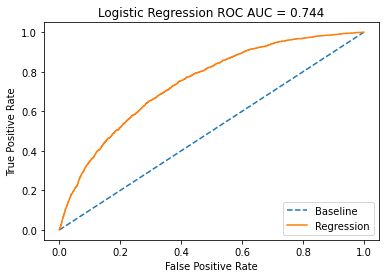

In [132]:
probs = model.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [133]:
from sklearn.model_selection import GridSearchCV

# Добавим типы регуляризации  penalty = ['l1', 'l2']
penalty = ['l1','l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=['l2'])

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=20, verbose=0)
best_model = clf.fit(X_train, y_train)

# View best hyperparameters
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

probs = best_model.predict_proba(X_test)
probs = probs[:,1]
print('roc_auc:', roc_auc_score(y_test, probs))

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Лучшее Penalty: l2
Лучшее C: 1.0
roc_auc: 0.7441048431537877


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


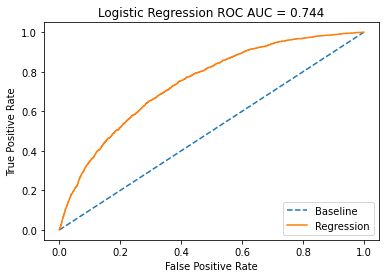

In [134]:
probs = best_model.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [135]:
# Используем класс LogisticRegressionCV.
from sklearn.linear_model import LogisticRegressionCV

# Сначала для значения penalty = 'l1'
for solver in ['saga', 'liblinear']:
    clf = LogisticRegressionCV(cv=5, random_state=0, verbose=0, penalty='l1', solver=solver).fit(X_train, y_train)
    probs = clf.predict_proba(X_test)
    probs = probs[:,1]
    print ("penalty = 'l1', solver = '", solver, "'roc_auc = ", roc_auc_score(y_test, probs))

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

penalty = 'l1', solver = ' saga 'roc_auc =  0.7450564868637322
penalty = 'l1', solver = ' liblinear 'roc_auc =  0.7446592562374963


In [136]:
# Теперь для значения penalty = 'l2'
for solver in ['newton-cg', 'lbfgs', 'sag']:
    clf = LogisticRegressionCV(cv=5, random_state=0, verbose=0, penalty='l2', solver=solver).fit(X_train, y_train)
    best_model = clf.fit(X_train, y_train)
    probs = clf.predict_proba(X_test)
    probs = probs[:,1]
    print ("penalty = 'l2', solver = '", solver, "'roc_auc = ", roc_auc_score(y_test, probs))


penalty = 'l2', solver = ' newton-cg 'roc_auc =  0.744708264661232
penalty = 'l2', solver = ' lbfgs 'roc_auc =  0.744708180018013


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


penalty = 'l2', solver = ' sag 'roc_auc =  0.7447083916260602


In [137]:
clf = LogisticRegressionCV(cv=5, random_state=0, verbose=0, penalty='elasticnet', solver='saga', l1_ratios=[0.5]).fit(X_train, y_train)
probs = clf.predict_proba(X_test)
probs = probs[:,1]
print ("penalty = 'elasticnet', solver = 'saga', 'roc_auc = ", roc_auc_score(y_test, probs))

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

penalty = 'elasticnet', solver = 'saga', 'roc_auc =  0.7448453866758284


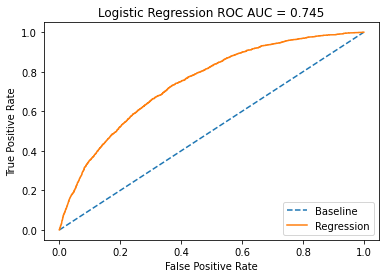

In [144]:
best_model = LogisticRegressionCV(cv=5, random_state=0).fit(X_train, y_train)

probs = best_model.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [139]:
best_model.get_params()

{'Cs': 10,
 'class_weight': None,
 'cv': 5,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1.0,
 'l1_ratios': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 0,
 'refit': True,
 'scoring': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0}

# Submission

In [149]:
test_data = df_preproc.query('sample == 0').drop(['sample','default'], axis=1)

In [147]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36349 entries, 0 to 36348
Data columns (total 53 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sex                36349 non-null  int64  
 1   age                36349 non-null  float64
 2   car                36349 non-null  int64  
 3   car_type           36349 non-null  int64  
 4   good_work          36349 non-null  int64  
 5   score_bki          36349 non-null  float64
 6   income             36349 non-null  float64
 7   foreign_passport   36349 non-null  int64  
 8   age_40             36349 non-null  int64  
 9   income_rank        36349 non-null  int64  
 10  education_ACD      36349 non-null  uint8  
 11  education_GRD      36349 non-null  uint8  
 12  education_N/A      36349 non-null  uint8  
 13  education_PGR      36349 non-null  uint8  
 14  education_SCH      36349 non-null  uint8  
 15  education_UGR      36349 non-null  uint8  
 16  decline_app_cnt_0  363

In [150]:
y_pred = best_model.predict_proba(test_data.drop(['client_id'], axis=1))
test_data['default'] = y_pred[:, 1]
sample_submission = test_data[['client_id','default']]
sample_submission

,client_id,default
0,74835,0.043657
1,17527,0.287984
2,75683,0.070839
3,26883,0.086255
4,28862,0.030742
...,...,...
36344,83775,0.369080
36345,106254,0.021852
36346,81852,0.351987
36347,1971,0.209249


In [151]:
sample_submission.to_csv('sample_submission.csv', index = False)